In [1]:
# Tại bên này có nhiều version, bỏ qua
import sys
print(sys.executable)
assert str(sys.executable) == 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python38\\python.exe'

C:\Users\user\AppData\Local\Programs\Python\Python38\python.exe


In [2]:
import datetime
from datetime import date
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from requests_html import HTML
import time

%matplotlib inline
import matplotlib.pyplot as plt
import os.path
import numpy as np
import math

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from keras import callbacks
import time

## Visualize

In [3]:
def plot_stock(df, symbol):
    plt.figure(figsize = (18,7))
    plt.plot(df['Close'])
    plt.title(symbol)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Close Price',fontsize=14)

    plt.show()
    
def plot_validation(Y, predicted_Y, scaler, title=''):
    valid_vs_prediction = pd.DataFrame({'Close': Y})
    valid_vs_prediction['Predicted'] = scaler.inverse_transform(predicted_Y[:, np.newaxis]).reshape(len(predicted_Y)) #Từ scaled -> giá trị cũ
    
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(valid_vs_prediction[['Close', 'Predicted']])
    plt.legend(['Actual', 'Predicted'], loc='lower right')
    plt.show()
    
def plot_prediction(valid_data, predictions, next_predict, scaler, show=None, title=''):
    valid_vs_prediction = pd.DataFrame(valid_data)
    valid_vs_prediction['Predicted'] = scaler.inverse_transform(predictions) #Từ scaled -> giá trị cũ
    valid_vs_prediction
    
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    if show==None or show > len(valid_data): show = 0
    plt.plot(valid_vs_prediction[['Close', 'Predicted']][-show:])
    plt.plot(next_predict)
    plt.legend(['Val', 'Predicted', 'Prediction'], loc='lower right')
    plt.show()

# 2. Preprocess

In [4]:
def fill_time_point(dataframe):
    df = dataframe.copy()
    
    i = 0
    curr = df.index[0]
    end = df.index[-1]

    while curr != end:
        curr += datetime.timedelta(days=1)
        i+=1
        if curr != df.index[i]:
            before = df.iloc[i-1].to_numpy().copy()
            after = df.iloc[i].to_numpy().copy()
            days_missed = (df.index[i] - curr).days
            avg = ((after - before)/(days_missed+1)).round(1)

            while curr != df.index[i]:
                before += avg
                fix = pd.DataFrame({'Open': before[0], 'High': before[1], 'Low': before[2], 'Close': before[3]}, index=[curr])
                df = df.append(fix)
                #print(fix)
                curr += datetime.timedelta(days=1)

    df.sort_index(inplace=True)
    return df

In [5]:
def read_the_fill_csv(filepath):
    df = pd.read_csv(filepath, parse_dates={'Datetime':['Date']}).iloc[::-1]
    df.set_index(['Datetime'], inplace = True)
    df_filled = fill_time_point(df)
    
    return df, df_filled

In [6]:
BVH, BVH_filled = read_the_fill_csv('BVH.csv')
BVH.shape, BVH_filled.shape

((2868, 4), (4193, 4))

# 3. Forecasting

## Split data

In [7]:
# Split train - validation - test
#        70%        15%       15%
def split_data(dataset):
    train_data, test_data = train_test_split(dataset, shuffle=False, test_size=0.15)
    train_data, validation_data = train_test_split(train_data, shuffle=False, test_size=0.177)
    
    return train_data, validation_data, test_data

In [8]:
def get_scaler(data):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(data.values[:, np.newaxis])
    
    return scaler

In [9]:
def convert_to_timestep(data, steps, lag=0):
    X = []
    Y = []

    for i in range(len(data)):
        end_ixd = i + steps

        if end_ixd > len(data)-1:
            break

        seq_x, seq_y = data[i:end_ixd-lag], data[end_ixd]
        X.append(np.array(seq_x))
        Y.append(seq_y)
        
    X = np.array(X).reshape(len(X), steps-lag, 1)
    Y = np.array(Y)
    
    return X,Y
    #return pd.DataFrame(data={'X': X, 'Y': Y})

In [10]:
train_data, validation_data, test_data = split_data(BVH_filled['Close'])

In [11]:
scaler = get_scaler(train_data)
train_data_scaled = scaler.transform(train_data.values[:, np.newaxis])[:,0]
val_data_scaled = scaler.transform(validation_data.values[:, np.newaxis])[:,0]
test_data_scaled = scaler.transform(test_data.values[:, np.newaxis])[:,0]

In [12]:
#X_test, Y_test = convert_to_timestep(test_data_scaled, steps=100, lag=3)

## Build LSTM model

In [13]:
def create_LSTM(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True,input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.25))
    model.add(Dense(units=50))
    model.add(Dense(units=1))
                    # lr=0.001
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [20]:
def train_LSTM(lag, step, batch_size, X_train, Y_train, X_val, Y_val):
    to_save = "models/LLDrDD_lag={0}_step={1}_batchsize={2}_earlystop_p=10.pkl".format(lag, step, batch_size)
    if not os.path.exists(to_save):
        model = create_LSTM((X_train.shape[1],1))
        earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 10, 
                                                restore_best_weights = True, verbose=1)

        starttime = time.time()
        print(" <<< Started", to_save, "at", time.strftime('%H:%M:%S', time.localtime(starttime)))

        model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                        batch_size=batch_size, verbose=0, epochs=100, callbacks =[earlystopping])

        model.save(to_save)
        print(" <<< Finished. Time elapsed:", time.time() - starttime)
    else:
        model = load_model(to_save)
        print(" === Loaded: ", to_save)
        
    return model

## Validation

In [21]:
def compare_LSTM(train_data, validation_data, list_steps, list_lag, list_batch_size):
    tf.random.set_seed(69)
    
    result = {l:list() for l in list_lag}
    
    for l in list_lag:
        for st in list_steps:
            
            X_train, Y_train = convert_to_timestep(train_data_scaled, steps=st, lag=l)
            X_val, Y_val = convert_to_timestep(val_data_scaled, steps=st, lag=l)
            
            for bs in list_batch_size:
                model = train_LSTM(l, st, bs, X_train, Y_train, X_val, Y_val)
                                    
                mse = np.mean(((scaler.inverse_transform(model.predict(X_val))
                       - scaler.inverse_transform(Y_val[:, np.newaxis]))**2))
                result[l].append({'Name': to_save, 'mse':mse, 'model': model})
                
    return result

In [ ]:
result = compare_LSTM(train_data, validation_data, list_steps=[100], list_lag=[5], list_batch_size=[64])

 <<< Started models/LLDrDD_lag=5_step=100_batchsize=64_earlystop_p=10.pkl at 03:51:23


In [ ]:
result[5]

In [ ]:
X_train, Y_train = convert_to_timestep(train_data_scaled, steps=100, lag=5)
X_val, Y_val = convert_to_timestep(val_data_scaled, steps=100, lag=5)
model = result[7][0]['model']

In [ ]:
plot_validation(validation_data[100:], model.predict(X_val)[:,0], scaler, title='Validation set')

In [ ]:
mse=np.mean(((scaler.inverse_transform(model.predict(X_val))
                       - scaler.inverse_transform(Y_val[:, np.newaxis]))**2))
mse

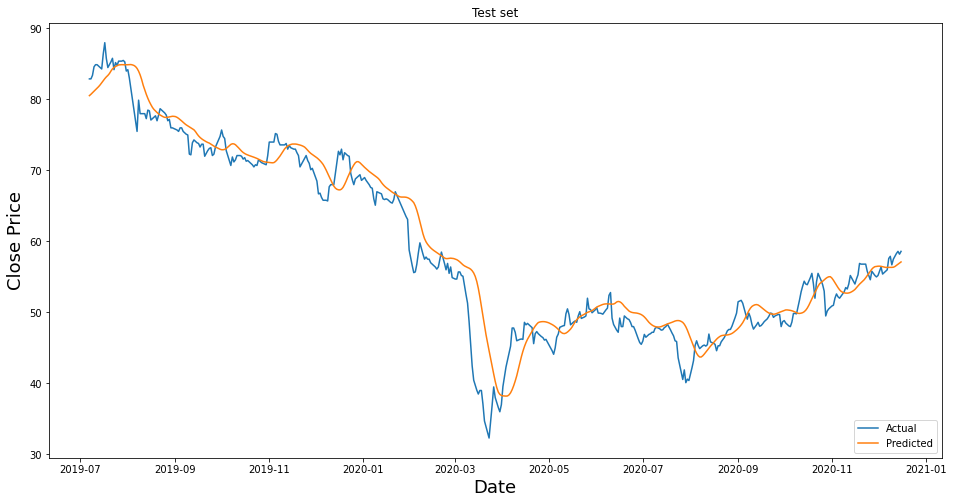

In [95]:
plot_validation(test_data[100:], model.predict(X_test)[:,0], scaler, title='Test set')

In [96]:
rmse=np.sqrt(np.mean(((scaler.inverse_transform(model.predict(X_test))
                       - scaler.inverse_transform(Y_test[:, np.newaxis]))**2)))
rmse

3.3974495918415735

## Prediction

In [23]:
def predict(model, scaler, data, time_window, num_of_date):
    x = scaler.transform(data[-time_window:].to_numpy().reshape(-1, 1))[:,0]

    prediction = []

    for i in range(num_of_date):
        y = model.predict(np.reshape(np.array(x), (1, time_window, 1)))
        #if i<3:
        #    print(x)
         #   print(y[0])
        x = np.delete(x, 0)
        x = np.append(x, y[0])
        prediction.append(y[0])
        
    unscaled_prediction = scaler.inverse_transform(prediction)
    
    idx = pd.date_range(data.index[-1], periods=num_of_date+1, freq='1d')[1:]
    return pd.Series(unscaled_prediction[:,0], index=idx)

In [24]:
plot_prediction(valid_data, predictions, predict(model, scaler, BVH_filled['Close'], time_window, 20), show = None, title='Next 20 days prediction')

NameError: name 'valid_data' is not defined

In [ ]:
plot_prediction(valid_data, predictions, predict(model, scaler, BVH_filled['Close'], time_window, 20), show = None, title='Next 20 days prediction')

In [ ]:
def random_predict(model, scaler, valid_data, time_window, num_of_date, points):
    predictions = []

    for p in points:
        if p < time_window or p > len(valid_data): continue
        predictions.append(predict(model, scaler, valid_data[:p], time_window, num_of_date))
          
    plt.figure(figsize=(16,8))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(valid_data)
    for p in predictions:
        plt.plot(p, color = 'g')
    plt.legend(['Val', 'Prediction'], loc='lower right')
    plt.show()

In [ ]:
random_predict(model, scaler, valid_data, time_window, 15, [100, 242, 300, 500, 560, 595, 690])

# Ref

https://insights.magestore.com/posts/giai-thuat-time-series-forecasting

https://www.datacamp.com/community/tutorials/lstm-python-stock-market

https://randerson112358.medium.com/stock-price-prediction-using-python-machine-learning-e82a039ac2bb

https://viblo.asia/p/lam-quen-voi-keras-gGJ59mxJ5X2

https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

https://viblo.asia/p/optimizer-hieu-sau-ve-cac-thuat-toan-toi-uu-gdsgdadam-Qbq5QQ9E5D8

https://www.phamduytung.com/blog/2018-10-02-understanding-epoch-batchsize-iterations/